# Development in Danish unemployment, 2007-2020

Imports and set magics:

In [1]:
import numpy as np
import pandas as pd
import datetime
import ipywidgets as widgets
import pandas_datareader 
import pydst # install with pip install git+https://github.com/elben10/pydst
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid') 

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
#No local modules used

# Read, clean and merge data

Begin to download unemployment data using pydst - Danish Statistical Banks Python integration:

In [2]:
Dst = pydst.Dst(lang='en')
Dst.get_subjects()
tables = Dst.get_tables(subjects=['04'])
tables[tables.id == 'AUF01']
unempl_pers = Dst.get_variables(table_id='AUF01')

We find the possible IDs for the chosen variables within the table and prints them with their associated text to describe the IDs:

In [3]:
for id in ['YDELSESTYPE','ALDER','KØN']:
    
    print(id)
    values = unempl_pers.loc[unempl_pers.id == id,['values']].values[0,0]
    for value in values:      
        print(f' id = {value["id"]}, text = {value["text"]}')

YDELSESTYPE
 id = TOT, text = Gross unemployment
 id = LDP, text = Net unemployed recipients of unemployment benefits
 id = LKT, text = Net unemployed recipients of social assistance
 id = ADP, text = Activation of persons on unemployment benefits
 id = AKT, text = Activation of persons on social assistance (prepared for employment)
ALDER
 id = TOT, text = Age, total
 id = 16-24, text = 16-24 years
 id = 25-29, text = 25-29 years
 id = 30-39, text = 30-39 years
 id = 40-49, text = 40-49 years
 id = 50-59, text = 50-59 years
 id = 6099, text = 60 year and over
KØN
 id = TOT, text = Total
 id = M, text = Men
 id = K, text = Women


We now use the IDs found to write, which variables we want to include for each column and import data from the table_id with the variables we want:

In [4]:
variables = {'OMRÅDE':['*'],'YDELSESTYPE':['TOT'],'ALDER':['TOT'],'KØN':['*'],'TID':['*']}
unempl_AUF1 = Dst.get_data(table_id= 'AUF01', variables=variables)
unempl_AUF2 = Dst.get_data(table_id= 'AUF02', variables=variables)

Rewrite the TID parameter to be in datetime (We go from ex. 2020M01 to 2020-01-01):

In [5]:
unempl_AUF1.loc[:,'TID']= pd.to_datetime(unempl_AUF1.loc[:,'TID'].str.replace('M',''),format='%Y%m')
unempl_AUF2.loc[:,'TID']= pd.to_datetime(unempl_AUF2.loc[:,'TID'].str.replace('M',''),format='%Y%m')

In [6]:
unempl_AUF2['TID'].max()

Timestamp('2020-08-01 00:00:00')

Since AUF2 has the actual unemployment numbers, but AUF1 have more recent data, we choose to merge these.

In [7]:
I = (unempl_AUF1["TID"] > "2020-08-01") #Choose to stack only rows in AUF1, where there are newer data than in AUF2
unempl_AUF1 = unempl_AUF1.loc[I == True] #Overwrite the variable, where I is true.
outer = pd.merge(unempl_AUF1, unempl_AUF2, how='outer') #merge the two data sets

In [8]:
outer

,OMRÅDE,YDELSESTYPE,ALDER,KØN,TID,AKASSE,INDHOLD
0,Province Sydjylland,Gross unemployment,"Age, total",Women,2020-09-01,Total,6736
1,Province Sydjylland,Gross unemployment,"Age, total",Men,2020-09-01,Total,6794
2,Province Sydjylland,Gross unemployment,"Age, total",Total,2020-09-01,Total,13530
3,Copenhagen,Gross unemployment,"Age, total",Women,2020-09-01,Total,10779
4,Copenhagen,Gross unemployment,"Age, total",Men,2020-09-01,Total,10261
...,...,...,...,...,...,...,...
59155,Region Syddanmark,Gross unemployment,"Age, total",Men,2019-06-01,Total,9474
59156,Region Syddanmark,Gross unemployment,"Age, total",Total,2019-06-01,Total,19495
59157,Rudersdal,Gross unemployment,"Age, total",Women,2019-06-01,Total,349
59158,Rudersdal,Gross unemployment,"Age, total",Men,2019-06-01,Total,309


**Beginning of data cleaning**

In [9]:
unempl = outer.copy()
unempl.rename(columns = {"OMRÅDE": "municipality", "ALDER":"age", "KØN":"gender","TID":"time","INDHOLD":"unemployed"}, inplace=True) #Renames the columns from Danish to English
drop_columns = ["YDELSESTYPE", "AKASSE"] #Drops the data from YDELSESTYPE and AKASSE as they are unimportant for this assignment
unempl.drop(drop_columns, axis=1, inplace=True)
unempl = unempl.sort_values(['municipality', 'time']) #Sorts the dataset by municipality then time

Deletes any row, where it isn't a municipality

In [10]:
I = unempl.municipality.str.contains('Region')
I |= unempl.municipality.str.contains('Province')
I |= unempl.municipality.str.contains('All Denmark')
unempl = unempl.loc[I == False] #Keep everything that isn't "I"

In [11]:
unempl

,municipality,age,gender,time,unemployed
6889,Aabenraa,"Age, total",Total,2007-01-01,1500
18306,Aabenraa,"Age, total",Women,2007-01-01,933
18307,Aabenraa,"Age, total",Men,2007-01-01,567
2369,Aabenraa,"Age, total",Total,2007-02-01,1443
19185,Aabenraa,"Age, total",Women,2007-02-01,882
...,...,...,...,...,...
1198,Ærø,"Age, total",Men,2021-01-01,56
1259,Ærø,"Age, total",Total,2021-01-01,107
1223,Ærø,"Age, total",Women,2021-02-01,54
1224,Ærø,"Age, total",Men,2021-02-01,57


Procent change on total for men and women 

In [12]:
unique_areas = unempl['municipality'].unique() #Creates an array of each unique municipality name

for area in unique_areas: #Takes each individual area with the restriction that gender = Total. Then it loops over each area and creates the pct change
    I = (unempl['municipality']==area) & (unempl['gender'] == 'Total')
    unempl.loc[I, 'pct change'] = unempl.loc[I,'unemployed'].pct_change(fill_method='ffill')

In [13]:

I = (unempl['municipality']=='Aabenraa') & (unempl['gender'] == 'Total')
unempl[I]

,municipality,age,gender,time,unemployed,pct change
6889,Aabenraa,"Age, total",Total,2007-01-01,1500,NaN
2369,Aabenraa,"Age, total",Total,2007-02-01,1443,-0.038000
6960,Aabenraa,"Age, total",Total,2007-03-01,1325,-0.081774
3195,Aabenraa,"Age, total",Total,2007-04-01,1306,-0.014340
3294,Aabenraa,"Age, total",Total,2007-05-01,1191,-0.088055
...,...,...,...,...,...,...
2045,Aabenraa,"Age, total",Total,2020-10-01,974,-0.025025
746,Aabenraa,"Age, total",Total,2020-11-01,933,-0.042094
1869,Aabenraa,"Age, total",Total,2020-12-01,971,0.040729
1914,Aabenraa,"Age, total",Total,2021-01-01,1057,0.088568


# Presentation of data and analysis

**Making graphs**

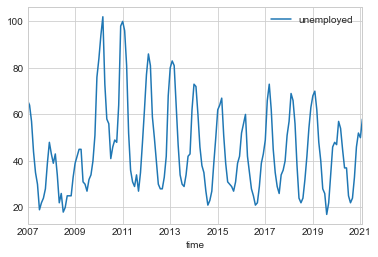

In [14]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

unempl.loc[(unempl['municipality'] == 'Samsø') &(unempl['gender'] == 'Men'),:].plot(ax=ax, x="time", y = "unemployed",legend=True);
plt.show()

Widget for unemployed sortable by municipality and gender

In [15]:
def plot_interact(df, municipality, gender):
    I = df['municipality'] == municipality
    I &= df['gender'] == gender
    df.loc[I,:].plot(x='time', y = 'unemployed', style='-o', legend=False)
widgets.interact(plot_interact, 
    df = widgets.fixed(unempl),
    municipality = widgets.Dropdown(description='Municipality', 
    options=unempl.municipality.unique(), 
    value='Roskilde'),
    gender = widgets.Dropdown(description='Gender',
    options=unempl.gender.unique(),
    value='Men')
);

interactive(children=(Dropdown(description='Municipality', index=73, options=('Aabenraa', 'Aalborg', 'Aarhus',…

Create widget to see pct_change for each municipality for gender = total

In [18]:
import matplotlib.dates as mdates

In [29]:
np.datetime64(, 'Y')

ValueError: Could not convert object to NumPy datetime

6889    2007-01-01
2369    2007-02-01
6960    2007-03-01
3195    2007-04-01
3294    2007-05-01
           ...    
563     2020-10-01
845     2020-11-01
1169    2020-12-01
1259    2021-01-01
1225    2021-02-01
Name: time, Length: 16830, dtype: object

In [45]:
unempl['date']=unempl['time'].dt.date


unempl_pct = unempl[unempl['gender'] == 'Total'] #create a variable only consisting of gender = total

def plot_interact_pct(df, municipality):
    I = df['municipality'] == municipality
    
    fig, ax = plt.subplots()
    df.loc[I,:].plot(x='date',y = 'pct change', kind='bar', style='-o', legend=False,ax=ax)
    
    plt.locator_params(axis='x', nbins=15) #Changes how many ticks are on the graph

widgets.interact(plot_interact_pct, 
    df = widgets.fixed(unempl_pct),
    municipality = widgets.Dropdown(description='Municipality', 
    options=unempl.municipality.unique(), 
    value='Roskilde')
);

interactive(children=(Dropdown(description='Municipality', index=73, options=('Aabenraa', 'Aalborg', 'Aarhus',…

From the above widgets we find that smaller municipalities have a decreasing trend in unemployment, while larger municiplaities such as copenhagen has a dip in between the financial crisis of 2008 and COVID-19 similar to agregate data.*

# Conclusion

COVID has had a large impact on unemployment in many municipalities, but in smaler areas the effect of COVID 19 can't be seen